In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras import (
    layers,
    models,
    losses,
    metrics,
    utils,
    optimizers,
    callbacks
)

import pandas as pd

2024-02-20 14:27:23.504749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 14:27:23.504840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 14:27:23.662417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#variables
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

**Prepare the Data**

In [3]:
train_data = utils.image_dataset_from_directory(
    "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files belonging to 1 classes.


In [4]:
#preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

In [5]:
# get a batch of images from the train_data

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    
    # check if batch is instance of a tuple
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [6]:
#function to display images

def display(images, n=10, size=(20,3), cmap="gray_r", as_type="float32", save_to=None):
  #display random images from each of the supplied arrays

  if images.max() > 1.0:
    images = images / 255.0
  elif images.min() < 0.0:
    images = (images + 1.0) /2.0

  plt.figure(figsize=size)
  for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].astype(as_type), cmap=cmap)
    plt.axis("off")

  if save_to:
    plt.savefig(save_to)
    print(f"\Saved to {save_to}")

  plt.show()

In [7]:
train_sample = sample_batch(train)

In [8]:
train_sample.shape

(128, 64, 64, 3)

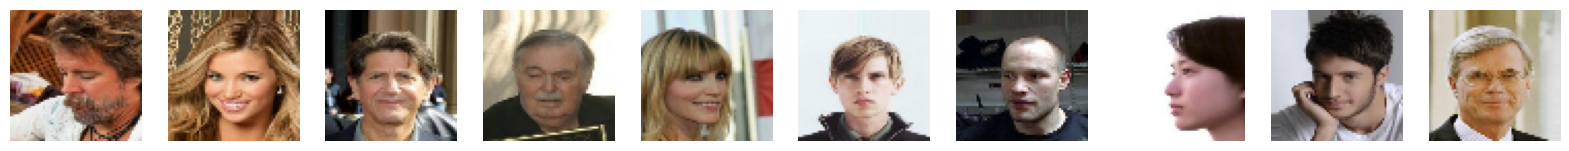

In [9]:
display(train_sample, cmap=None)

### Build the Variational AutoEncoder

In [10]:
# define the sampling layer

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
#define the encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(encoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# flatten to vector before dense layer
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normalization[0]

In [12]:
# define the decoder

decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

#connect the input to a dense layer
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

#reshape this vector into a tensor that can be fed as input into Conv2DTranspose
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# x = layers.Conv2DTranspose(
#     NUM_FEATURES,
#     3,
#     strides=2,
#     padding="same"
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(
    CHANNELS,
    3,
    strides=1,
    activation="sigmoid",
    padding="same"
)(x)

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                    

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# create the variational autoencoder

vae = VAE(encoder, decoder)

### Train the VAE

In [15]:
# compile the VAE
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
import os
output_directory = './output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [17]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# subclass of the callback class

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        
        """generates a tensor of random values from a normal distribution, where each row represents a random vector in a latent space"""
        # num of rows is determined by self.num_img
        # dimensionality of each vector is self.latent_dim
        
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *=255
        generated_images = generated_images.numpy()
        
        display(generated_images)
#         for i in range(self.num_img):
#             img = utils.array_to_img(generated_images[i])
#             display(generated_images)
#            img.save(os.path.join(output_directory, "generated_img_%03d_%d.png" % (epoch, i)))

In [18]:
# load old weights if required

if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

Epoch 1/10


I0000 00:00:1708439550.879489      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1583/1583 [==============================] - ETA: 0s - loss: 95.2665 - reconstruction_loss: 59.8504 - kl_loss: 18.4210

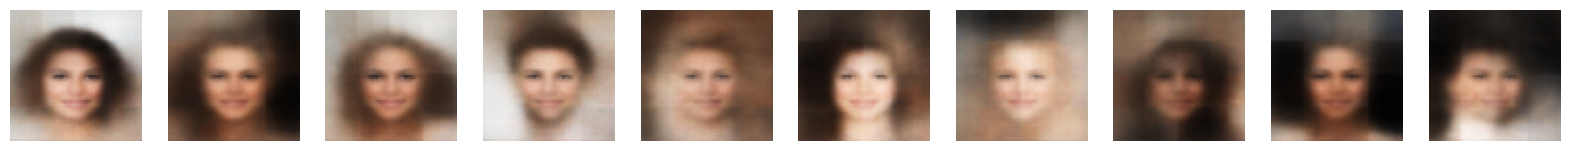

1583/1583 [==============================] - 249s 149ms/step - loss: 95.2558 - reconstruction_loss: 59.8504 - kl_loss: 18.4210
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 68.3455 - reconstruction_loss: 49.8403 - kl_loss: 17.8757

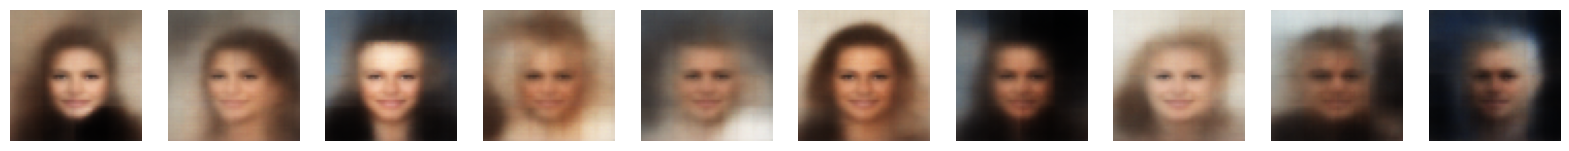

1583/1583 [==============================] - 219s 138ms/step - loss: 68.3451 - reconstruction_loss: 49.8403 - kl_loss: 17.8757
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 66.4798 - reconstruction_loss: 48.1565 - kl_loss: 17.9825

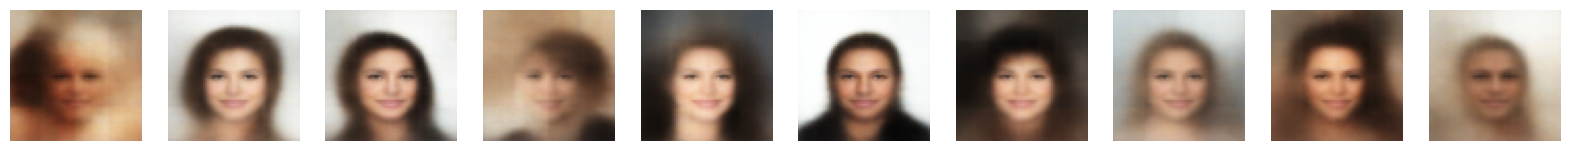

1583/1583 [==============================] - 219s 138ms/step - loss: 66.4796 - reconstruction_loss: 48.1565 - kl_loss: 17.9825
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 65.4713 - reconstruction_loss: 47.2752 - kl_loss: 18.0110

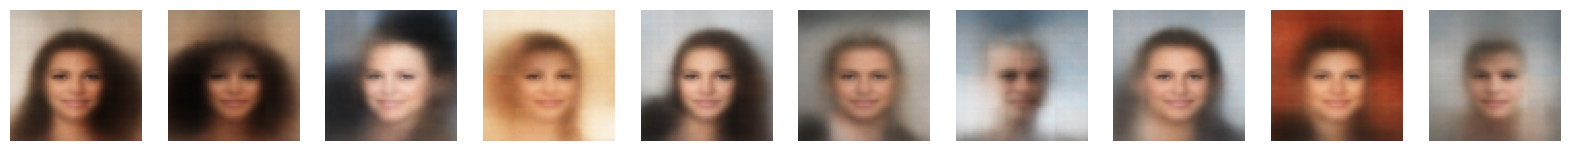

1583/1583 [==============================] - 219s 138ms/step - loss: 65.4712 - reconstruction_loss: 47.2752 - kl_loss: 18.0110
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 64.9493 - reconstruction_loss: 46.8066 - kl_loss: 18.0195

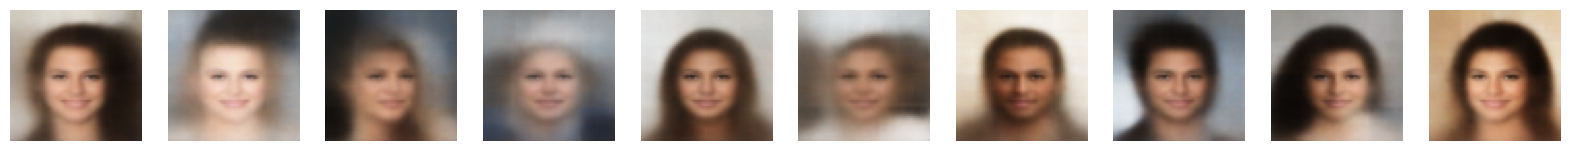

1583/1583 [==============================] - 219s 138ms/step - loss: 64.9492 - reconstruction_loss: 46.8066 - kl_loss: 18.0195
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 64.6180 - reconstruction_loss: 46.4525 - kl_loss: 18.0455

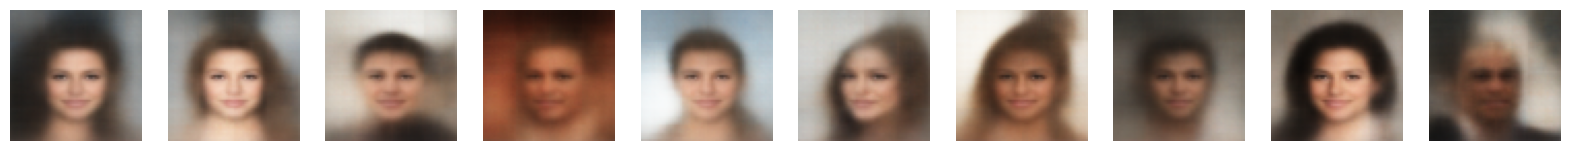

1583/1583 [==============================] - 219s 138ms/step - loss: 64.6180 - reconstruction_loss: 46.4525 - kl_loss: 18.0455
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.3279 - reconstruction_loss: 46.1361 - kl_loss: 18.0791

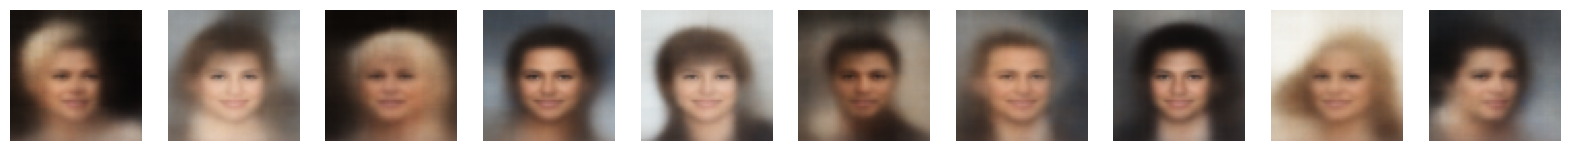

1583/1583 [==============================] - 219s 138ms/step - loss: 64.3279 - reconstruction_loss: 46.1361 - kl_loss: 18.0791
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.0643 - reconstruction_loss: 45.9115 - kl_loss: 18.0684

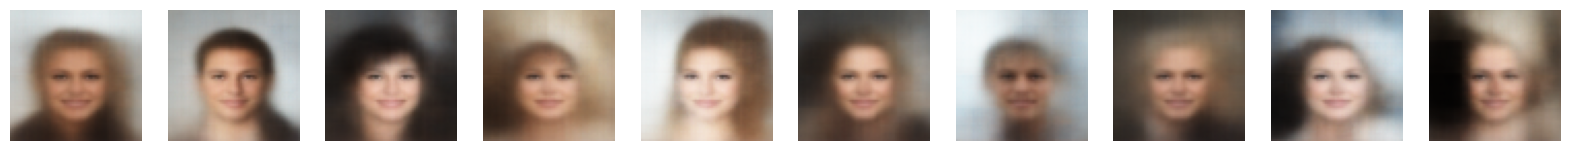

1583/1583 [==============================] - 219s 138ms/step - loss: 64.0642 - reconstruction_loss: 45.9115 - kl_loss: 18.0684
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 63.8985 - reconstruction_loss: 45.7149 - kl_loss: 18.0979

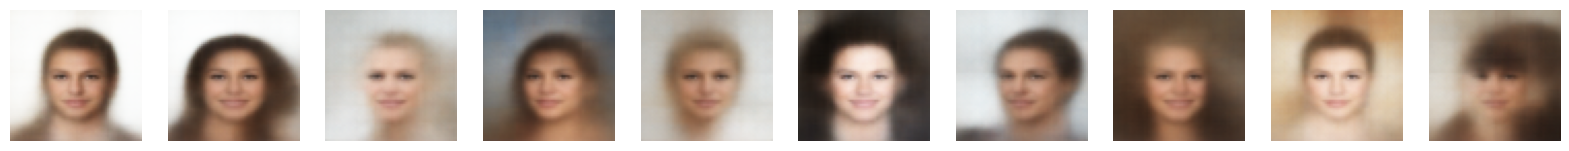

1583/1583 [==============================] - 219s 138ms/step - loss: 63.8984 - reconstruction_loss: 45.7149 - kl_loss: 18.0979
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 63.7297 - reconstruction_loss: 45.5312 - kl_loss: 18.0975

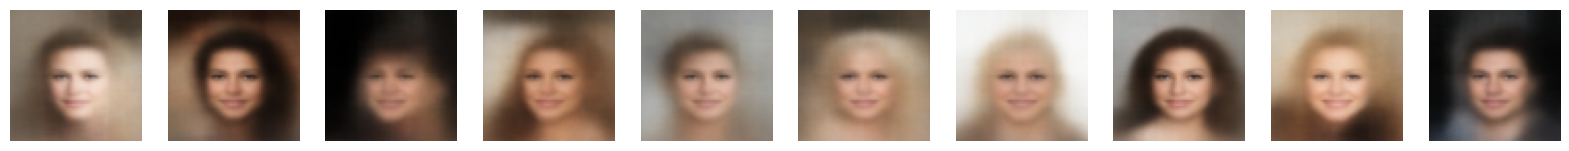

1583/1583 [==============================] - 219s 138ms/step - loss: 63.7297 - reconstruction_loss: 45.5312 - kl_loss: 18.0975


In [19]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [20]:
# save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

### Reconstruct the VAE

In [21]:
# select a subset of the test set
batches_to_predict = 1

example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 9ms/step
Example real faces


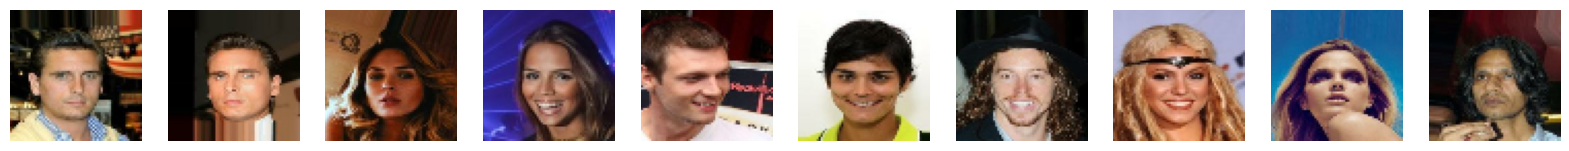

Reconstructions


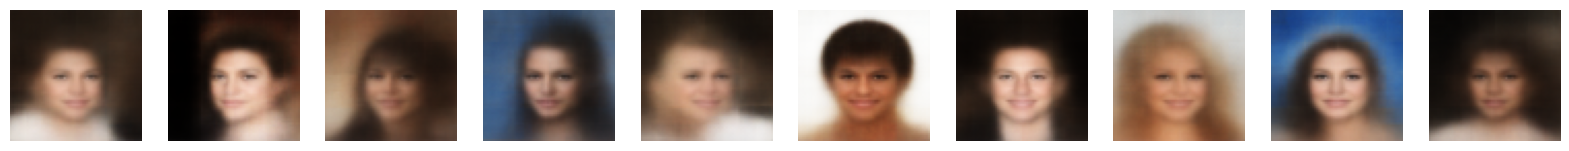

In [22]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## Latent Space Distribution

4/4 [==============================] - 0s 4ms/step


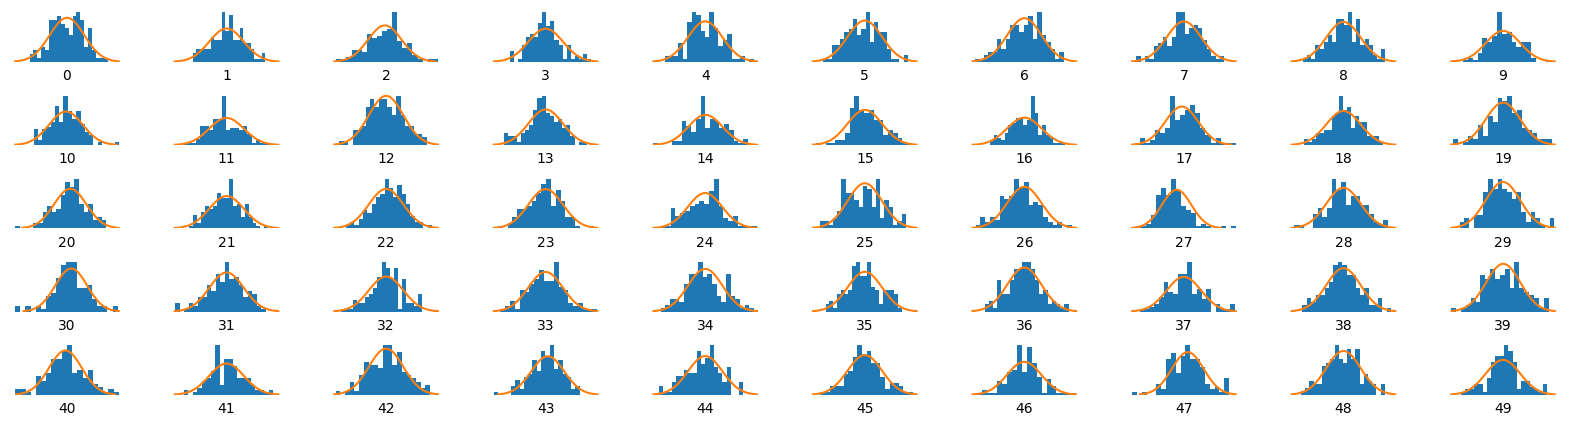

In [23]:
from scipy.stats import norm

# return the latent space from encoder
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3,3,100)

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))
    
plt.show()

## Generate new Faces

In [24]:
# sample points in the latent space from standard normal distribution

grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [25]:
# decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 756ms/step


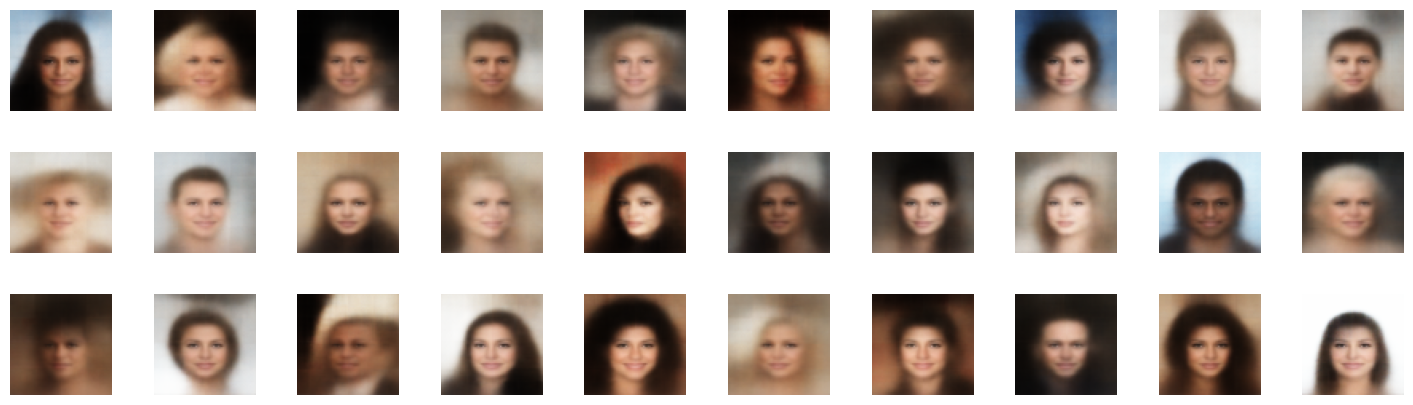

In [26]:
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax  = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## Manipulate the Images

In [27]:
# load the label dataset
attributes = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [28]:
# load the face data with label attached
LABEL = "Blond_Hair"
labelled_test = utils.image_dataset_from_directory(
    "/kaggle/input/celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [29]:
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

In [30]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


In [31]:
# fint the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.185    : 1.441    : 3.588    : 3.588
44    : 2.119    : 0.932    : 2.769    : -0.819
65    : 1.183    : 0.528    : 2.38    : -0.389
87    : 0.792    : 0.369    : 2.151    : -0.229
110    : 0.721    : 0.302    : 2.034    : -0.117
128    : 0.511    : 0.263    : 1.959    : -0.076
150    : 0.481    : 0.223    : 1.922    : -0.037
171    : 0.426    : 0.171    : 1.892    : -0.03
197    : 0.421    : 0.17    : 1.823    : -0.069
218    : 0.32    : 0.144    : 1.793    : -0.03
241    : 0.327    : 0.131    : 1.753    : -0.04
260    : 0.256    : 0.109    : 1.741    : -0.011
282    : 0.231    : 0.111    : 1.726    : -0.015
302    : 0.22    : 0.104    : 1.677    : -0.049
317    : 0.184    : 0.095    : 1.665    : -0.012
337    : 0.202    : 0.087    : 1.649    : -0.016
356    : 0.161    : 0.084    : 1.628    : -0.021
377    : 0.191    : 0.078    : 1.606    : -0.021
395    : 0.156    : 0.076    : 1.585    : -0.021
415    : 0.

In [32]:
def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


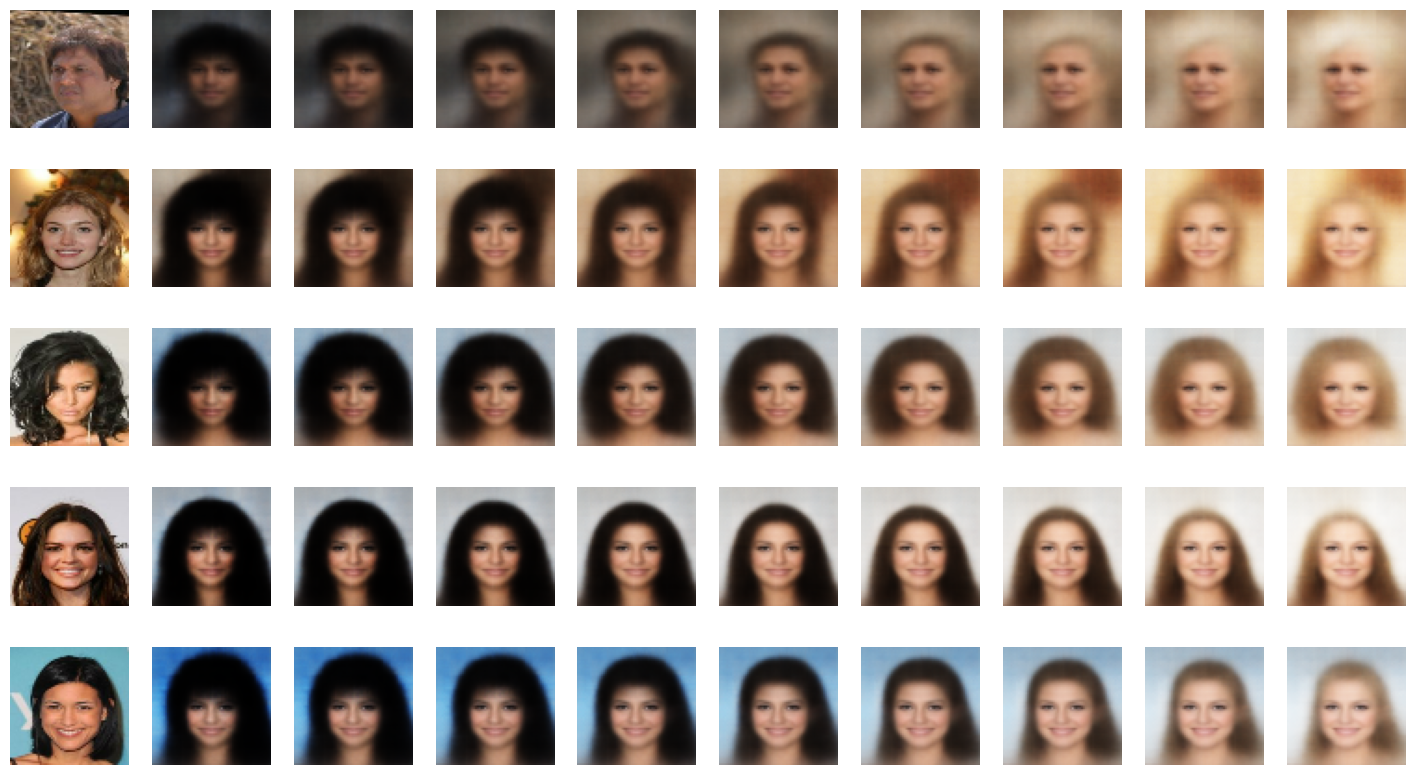

In [33]:
add_vector_to_images(labelled, vae, attribute_vec)

In [34]:
def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)
    # take two images
    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    
    print(example_images.shape)
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

(128, 64, 64, 3)


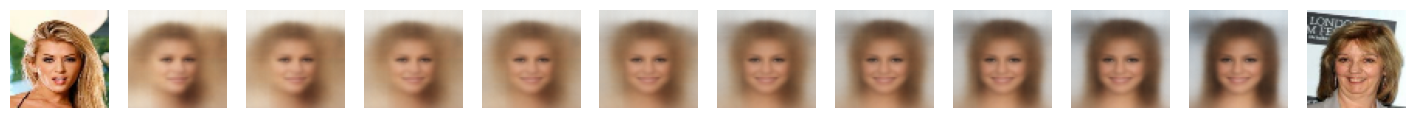

In [35]:
morph_faces(labelled, vae)